<div style="
    background-color: #A3C1E1;
    color: #1E1E1E;
    padding: 15px;
    border-radius: 10px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin-bottom: 20px;">
     Audit qualité des données Cartofriches – Phase EDA & Nettoyage
</div>

## I. Objectif  
Cartofriche est une application recenssant les données des friches en France, celle ci se présentent sous deux formes, une carte interactive affichant:  
• la liste des friches par zones et leur statuts avec projets en cours ou non. avec 14 986 données complétées. et des donnees interactives textuelles complétant les informations.  
• Les données agrégées sous forme de tableau contenant 28115 lignes.  
• Et enfin les données issues des différents observatoires. 7239 lignes  

L'objectif de ce Notebook est de travailler sur la qualités des données, leur complétude les valeurs manquantes les doublons, et afin de préparer les données éventuellement pour les analyses statistiques et pour la modélisation.
De comprendre les incohérences entre les quantités de données entre la carte et les tableaux.

Problématique comment la qualité des données affecte l'éxpérience utilisateur et la pertinence de l'utilisation de l'application?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

df = pd.read_csv(r"C:\Users\rovar\Downloads\friches-standard.csv",sep = ";")

C:\Users\rovar\AppData\Local\Temp\ipykernel_12336\854608870.py:6: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\rovar\Downloads\friches-standard.csv",sep = ";")


## Description des jeux de données 
les données cartofriche sont issues de data.gouv, 
Le dataset comprend les données issues:  
• des données gouvernementales  
• les données issues des observatoires 

Le jeu de donnée gouvernementale comprend 50 colonnes 
'Afin de constituer une base nationale de pré-recensement des friches, le Cerema s'est appuyé sur deux sources de données :

**BASOL** est une base de données nationale sur les sites et sols potentiellement pollués appelant une action des pouvoirs publics, produites par le Ministère de la Transition Ecologique ; les données utilisées sont issues du travail de consolidation de la base réalisé par le collectif Lou Dupont, et diffusé sur data.gouv.fr ;  
**BASIAS** est une base de données de l’inventaire historique des sites industriels et activités de service, produites par le Ministère de la Transition Ecologique et le BRGM ;  les données utilisées sont également issues du travail de consolidation de la base réalisé par le collectif Lou Dupont, et diffusé sur data.gouv.fr.'  

__ref__ https://artificialisation.developpement-durable.gouv.fr/agir-et-etre-accompagne/cartofriches/donnees-utilisees

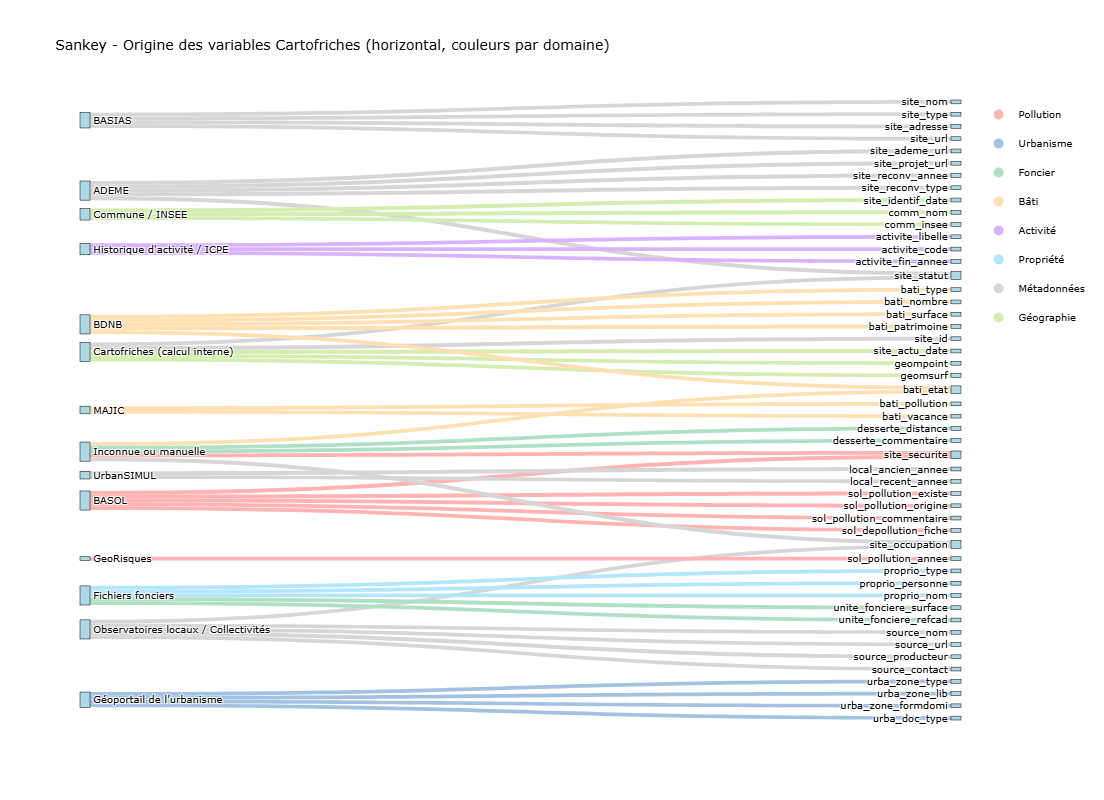

In [128]:
# Dictionnaire source → variables
source_variable_links = {
    "ADEME": ["site_ademe_url", "site_projet_url", "site_reconv_annee", "site_reconv_type", "site_statut"],
    "BASIAS": ["site_nom", "site_type", "site_adresse", "site_url"],
    "BASOL": ["site_securite", "sol_pollution_existe", "sol_pollution_origine", "sol_pollution_commentaire", "sol_depollution_fiche"],
    "Observatoires locaux / Collectivités": ["source_nom", "source_producteur", "source_contact", "site_occupation", "source_url"],
    "UrbanSIMUL": ["local_ancien_annee", "local_recent_annee"],
    "Cartofriches (calcul interne)": ["site_id", "site_actu_date", "geompoint", "geomsurf", "site_statut"],
    "Commune / INSEE": ["comm_nom", "comm_insee", "site_identif_date"],
    "Fichiers fonciers": ["proprio_type", "proprio_personne", "proprio_nom", "unite_fonciere_refcad", "unite_fonciere_surface"],
    "GeoRisques": ["sol_pollution_annee"],
    "Géoportail de l’urbanisme": ["urba_zone_type", "urba_zone_lib", "urba_zone_formdomi", "urba_doc_type"],
    "BDNB": ["bati_type", "bati_nombre", "bati_surface", "bati_etat", "bati_patrimoine"],
    "MAJIC": ["bati_pollution", "bati_vacance"],
    "Historique d'activité / ICPE": ["activite_libelle", "activite_code", "activite_fin_annee"],
    "Inconnue ou manuelle": ["site_securite", "site_occupation", "bati_etat", "desserte_distance", "desserte_commentaire"]
}

# Dictionnaire domaine → variables
domain_variables = {
    "Pollution": ["site_securite", "sol_pollution_existe", "sol_pollution_origine", "sol_pollution_commentaire", "sol_pollution_annee", "sol_depollution_fiche"],
    "Urbanisme": ["urba_zone_type", "urba_zone_lib", "urba_zone_formdomi", "urba_doc_type"],
    "Foncier": ["unite_fonciere_refcad", "unite_fonciere_surface", "desserte_distance", "desserte_commentaire"],
    "Bâti": ["bati_type", "bati_nombre", "bati_surface", "bati_pollution", "bati_vacance", "bati_patrimoine", "bati_etat"],
    "Activité": ["activite_libelle", "activite_code", "activite_fin_annee"],
    "Propriété": ["proprio_type", "proprio_personne", "proprio_nom"],
    "Métadonnées": ["source_nom", "source_url", "source_producteur", "source_contact", "site_ademe_url", "site_projet_url", "site_url", "site_id", "site_statut", "site_nom", "site_type", "site_adresse", "site_occupation", "site_reconv_annee", "site_reconv_type"],
    "Géographie": ["comm_nom", "comm_insee", "site_identif_date", "site_actu_date", "geompoint", "geomsurf"]
}

# Couleurs par domaine
domain_colors = {
    "Pollution": "#FFB3B3", "Urbanisme": "#A3C1E1", "Foncier": "#B0E0C4", "Bâti": "#FFE0B2",
    "Activité": "#D9B3FF", "Propriété": "#B3E5FC", "Métadonnées": "#D6D6D6", "Géographie": "#D4EDB0"
}


# Inversion pour avoir variable → domaine
variable_domains = {var: domain for domain, vars in domain_variables.items() for var in vars}

# Construction des liens
sources, targets, values, link_colors = [], [], [], []
for source, vars in source_variable_links.items():
    for var in vars:
        sources.append(source)
        targets.append(var)
        values.append(1)

        domain = variable_domains.get(var, "Métadonnées")
        if domain not in domain_colors:
            print(f"[⚠️] Domaine inconnu : {domain}")
        color = domain_colors.get(domain, "lightgray")
        link_colors.append(color)

# Ordre des labels (source d’abord, cibles ensuite, sans doublons)
ordered_sources = list(source_variable_links.keys())
ordered_targets = [
    'site_id', 'site_nom', 'site_type', 'site_adresse', 'site_identif_date',
    'site_actu_date', 'site_url', 'site_ademe_url', 'site_securite',
    'site_occupation', 'site_statut', 'site_projet_url',
    'site_reconv_annee', 'site_reconv_type', 'activite_libelle',
    'activite_code', 'activite_fin_annee', 'comm_nom', 'comm_insee',
    'bati_type', 'bati_nombre', 'bati_surface', 'bati_pollution',
    'bati_vacance', 'bati_patrimoine', 'bati_etat', 'local_ancien_annee',
    'local_recent_annee', 'proprio_type', 'proprio_personne', 'proprio_nom',
    'sol_pollution_annee', 'sol_pollution_existe', 'sol_pollution_origine',
    'sol_pollution_commentaire', 'sol_depollution_fiche',
    'unite_fonciere_surface', 'unite_fonciere_refcad', 'urba_zone_type',
    'urba_zone_lib', 'urba_zone_formdomi', 'urba_doc_type',
    'desserte_distance', 'desserte_commentaire', 'source_nom', 'source_url',
    'source_producteur', 'source_contact', 'geompoint', 'geomsurf']

labels = ordered_sources + ordered_targets
label_indices = {label: i for i, label in enumerate(labels)}
source_ids = [label_indices[s] for s in sources]
target_ids = [label_indices[t] for t in targets]

# Sankey plot
fig = go.Figure(data=[go.Sankey(
    orientation='h',
    arrangement="snap",
    node=dict(
        pad=30,
        thickness=10,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightblue"
    ),
    link=dict(
        source=source_ids,
        target=target_ids,
        value=values,
        color=link_colors
    )
)])

# Légende des domaines
for domain, color in domain_colors.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=10, color=color),
        legendgroup=domain,
        showlegend=True,
        name=domain
    ))

# Mise en forme
fig.update_layout(
    title_text="Sankey - Origine des variables Cartofriches (horizontal, couleurs par domaine)",
    font_size=10,
    width=1000,
    height=800,
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False),
)

fig.write_html("/mnt/data/sankey_cartofriches_horizontal_domaine.html")
fig.show()

## II. Audit Qualité

In [25]:
#Audit qualité
audit_report = []

for col in df.columns:
    series = df[col]
    audit_report.append({
        "Colonne": col,
        "Type": series.dtype,
        "Nb valeurs uniques": series.nunique(dropna=True),
        "Top valeur": series.mode().iloc[0] if not series.mode().empty else None,
        "Fréquence top valeur": series.value_counts(dropna=True).iloc[0] if not series.value_counts(dropna=True).empty else None,
        "Nb de NaN": series.isna().sum(),
        "% de NaN": round(series.isna().mean() * 100, 2)
    })

audit_df = pd.DataFrame(audit_report)
audit_df

,Colonne,Type,Nb valeurs uniques,Top valeur,Fréquence top valeur,Nb de NaN,% de NaN
0,site_id,object,28115,01001_32316,1.0,0,0.00
1,site_nom,object,24071,Décharge,415.0,0,0.00
2,site_type,object,19,inconnu,16005.0,0,0.00
3,site_adresse,object,3713,LE VILLAGE,30.0,24125,85.81
4,site_identif_date,object,581,2022-10-10,15736.0,0,0.00
5,site_actu_date,object,532,2022-10-10,15587.0,0,0.00
6,site_url,object,16939,https://www.suippes.fr/9143-2/,14.0,11120,39.55
7,site_ademe_url,float64,0,None,NaN,28115,100.00
8,site_securite,object,5,inconnu,20132.0,5822,20.71
9,site_occupation,object,20,inconnu,25850.0,0,0.00


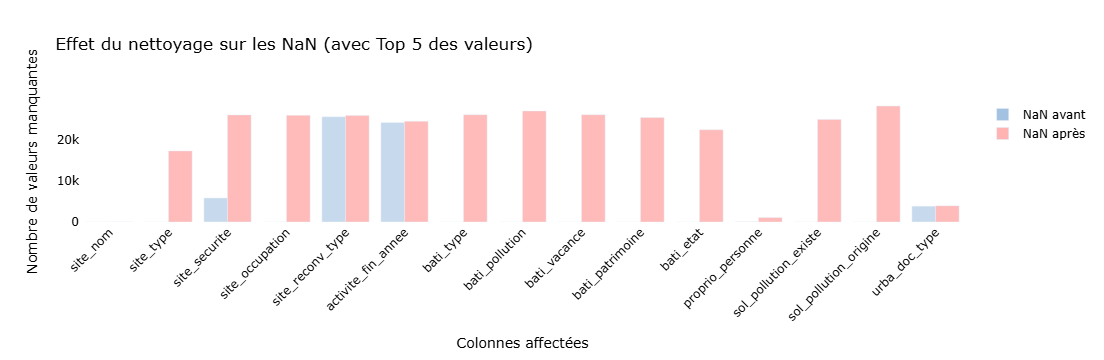

In [82]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=cols_affectees,
    y=na_avant_filtered,
    name='NaN avant',
    hovertext=hover_texts,
    hoverinfo='text',
    marker=dict(color='#A3C1E1', opacity=0.6)  # bleu pastel
))

fig.add_trace(go.Bar(
    x=cols_affectees,
    y=na_apres_filtered,
    name='NaN après',
    hovertext=hover_texts,
    hoverinfo='text',
    marker=dict(color='#FFB3B3', opacity=0.9)  # rose pastel
))

fig.update_layout(
    title="Effet du nettoyage sur les NaN (avec Top 5 des valeurs)",
    xaxis_title="Colonnes affectées",
    yaxis_title="Nombre de valeurs manquantes",
    barmode='group',
    xaxis_tickangle=-45,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black')
)

In [115]:
df.columns

Index(['site_id', 'site_nom', 'site_type', 'site_adresse', 'site_identif_date',
       'site_actu_date', 'site_url', 'site_ademe_url', 'site_securite',
       'site_occupation', 'site_statut', 'site_projet_url',
       'site_reconv_annee', 'site_reconv_type', 'activite_libelle',
       'activite_code', 'activite_fin_annee', 'comm_nom', 'comm_insee',
       'bati_type', 'bati_nombre', 'bati_surface', 'bati_pollution',
       'bati_vacance', 'bati_patrimoine', 'bati_etat', 'local_ancien_annee',
       'local_recent_annee', 'proprio_type', 'proprio_personne', 'proprio_nom',
       'sol_pollution_annee', 'sol_pollution_existe', 'sol_pollution_origine',
       'sol_pollution_commentaire', 'sol_depollution_fiche',
       'unite_fonciere_surface', 'unite_fonciere_refcad', 'urba_zone_type',
       'urba_zone_lib', 'urba_zone_formdomi', 'urba_doc_type',
       'desserte_distance', 'desserte_commentaire', 'source_nom', 'source_url',
       'source_producteur', 'source_contact', 'geompoint', 'geo

## Aperçu de la répartition des Valeurs manquantes dans le temps

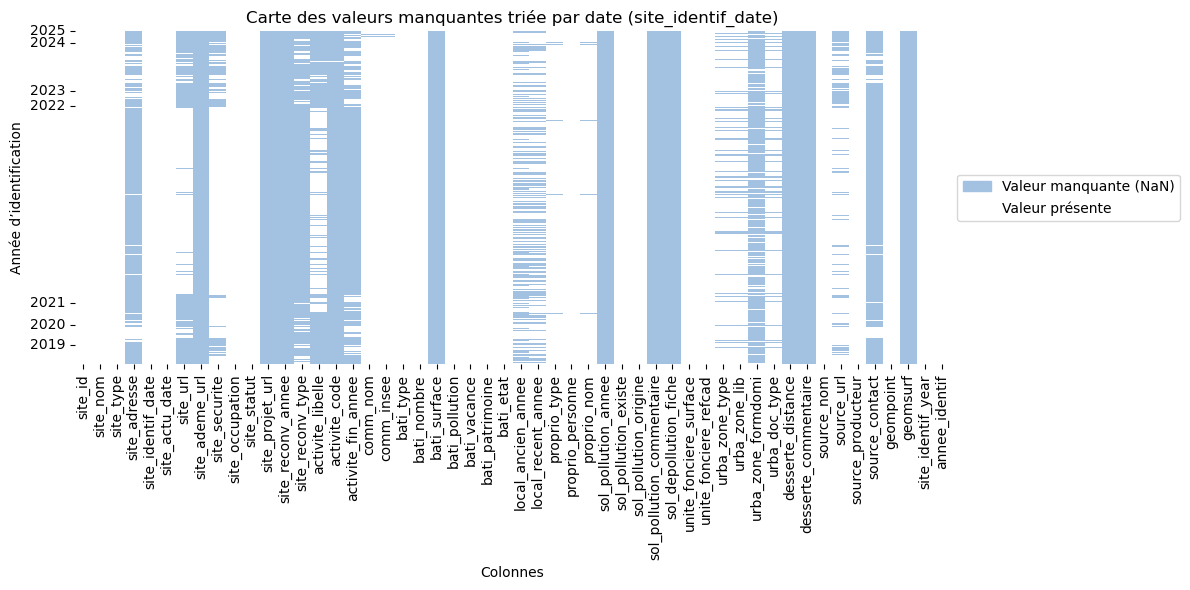

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Conversion et extraction de l'année
df["site_identif_date"] = pd.to_datetime(df["site_identif_date"], errors='coerce')
df["annee_identif"] = df["site_identif_date"].dt.year

# 2. Tri décroissant par la date
df_sorted = df.sort_values("site_identif_date", ascending=False)

# 3. Création de la heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    df_sorted.isna(),
    cmap=sns.color_palette(["white", '#A3C1E1']),
    cbar=False
)

# 4. Préparation des ticks d’année espacés
annees = df_sorted["annee_identif"].fillna(0).astype(int)
yticks_pos = []
yticks_labels = []
derniere_annee = None

for i, annee in enumerate(annees):
    if annee != derniere_annee and 2019 <= annee <= 2025:
        yticks_pos.append(i)
        yticks_labels.append(str(annee))
        derniere_annee = annee

plt.yticks(yticks_pos, yticks_labels, fontsize=10)

# 5. Légende personnalisée
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#A3C1E1', edgecolor='#A3C1E1', label='Valeur manquante (NaN)'),
    Patch(facecolor='white', edgecolor='white', label='Valeur présente')
]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.title("Carte des valeurs manquantes triée par date (site_identif_date)")
plt.xlabel("Colonnes", fontsize=10)
plt.ylabel("Année d’identification", fontsize=10)
plt.tight_layout()
plt.show()

In [34]:
df.columns

Index(['site_id', 'site_nom', 'site_type', 'site_adresse', 'site_identif_date',
       'site_actu_date', 'site_url', 'site_ademe_url', 'site_securite',
       'site_occupation', 'site_statut', 'site_projet_url',
       'site_reconv_annee', 'site_reconv_type', 'activite_libelle',
       'activite_code', 'activite_fin_annee', 'comm_nom', 'comm_insee',
       'bati_type', 'bati_nombre', 'bati_surface', 'bati_pollution',
       'bati_vacance', 'bati_patrimoine', 'bati_etat', 'local_ancien_annee',
       'local_recent_annee', 'proprio_type', 'proprio_personne', 'proprio_nom',
       'sol_pollution_annee', 'sol_pollution_existe', 'sol_pollution_origine',
       'sol_pollution_commentaire', 'sol_depollution_fiche',
       'unite_fonciere_surface', 'unite_fonciere_refcad', 'urba_zone_type',
       'urba_zone_lib', 'urba_zone_formdomi', 'urba_doc_type',
       'desserte_distance', 'desserte_commentaire', 'source_nom', 'source_url',
       'source_producteur', 'source_contact', 'geompoint', 'geo

In [30]:
print(df["site_identif_date"].iloc[20210])
print(df["site_identif_date"].iloc[27187]) 

2022-10-10 00:00:00
2021-12-31 00:00:00


**Commentaire:** Les données ci dessus montrent la répartition des Na dans le temps, on constate une zone entre 12/2021 10/2022 ou la complétude de certainnes données comme **site_url, site_securite, activite_libelle** sont plus importantes
⚠️problématique qui gére ces données, y a t 'il une maintenance automatique y a t'il des observatoires qui complètent moins bien 

#### Feuille de route:
Données gouvernementales (friches-standard.csv)
- les valeurs manquantes 
- ~~doublons~~ à vérifier  par subset 
- unifomisation des features et des types, uniformisation de la casse 
- enrichissement des données : croisement  datasets gouvernementales avec datasets des observatoires
- enrcichissement scrapping gpkg (données textuelles sur l'api) 
- enrichissement avec données textuelles
- enrichissement avec données externes ex( données toxicologiques)
- analyse statistique descriptive et analyse sur l'équilibre des données
 
#### Brain storm
problèmes rencontrés: arborescence pour accéder aux données annexes (eg trop complexes.
Incohérence des volumes entre les différents datasets carte, enrichies et observatoires -> besoin d'uniformisation pour faciliter la visibilité
Pas assez d'indicateur pour prendre des décisions financieres et extra financieres: besoin d'agrégation 
Pas assez d'indicateur écologique alors que c'est une application faite dans le cadre de l'écologie

## III. ANALYSE DETAILLEE DES VARIABLES

**La complétude et la pertinence** de chaque  variable est analysée dans un premier temps pour évaluer la qualité générale des données fournies par cartofriche et leur provenance: 

In [2]:
#Analyse de typologie 
import pandas as pd
import re

def detect_typo_patterns(series):
    audit = []
    for val in series.dropna().unique():
        val_str = str(val)
        length = len(val_str)
        pattern = re.sub(r'\d', '0', val_str)  # transforme 61214_34555 → 00000_00000
        pattern = re.sub(r'[a-zA-Z]', 'A', pattern)  # si lettres présentes
        pattern = re.sub(r'[^0A_]', 'X', pattern)  # tout autre caractère

        audit.append({
            "Exemple": val_str,
            "Longueur": length,
            "Pattern typologique": pattern,
            "Fréquence": series[series == val].count()
        })

    df_patterns = pd.DataFrame(audit)
    return df_patterns.groupby(["Pattern typologique"]).agg({
        "Exemple": "first",
        "Longueur": "first",
        "Fréquence": "sum"
    }).sort_values("Fréquence", ascending=False).reset_index()


### 1) site_nom

In [35]:
#site_id
detect_typo_patterns(df["site_nom"])

,Pattern typologique,Exemple,Longueur,Fréquence
0,00000_00000,93027_35701,11,1923
1,AAAAAA,Friche,6,432
2,AXAAAAAA,Décharge,8,432
3,AAAAAAAA,Sotralec,8,309
4,AAAAAAAXAAAAAAA,Elevage avicole,15,272
...,...,...,...,...
13845,AAAAAAX00XAAAAAXAAXAAAAA,Maison 12 route de flers,24,1
13846,AAAAAAX00XAAAX0XAAXAAAAA,Terril 39 dit 5 de Noeux,24,1
13847,AAAAAAX00XAAAX0XAAXAAAAAXAAAXAAAAA,Terril 60 dit 2 de Noeux les Mines,34,1
13848,AAAAAAX00XAAAXAAAAAAXAAAA,Maison 47 rue sainte anne,25,1


⚠️vérifier pertinence existence site_nom et site_id et redondance, Pourquoi il y a des données de la forme 00000_00000
quels lignes ont tendance a avoir des données manquantes? pourquoi? besoin de standardisé l'entrée des données? 

### 2) site_id

In [21]:
detect_typo_patterns(df["site_id"])

,Pattern typologique,Exemple,Longueur,Fréquence
0,00000_00000,61214_34555,11,18750
1,00000_0000,62178_4393,10,8128
2,00000_000,16154_221,9,869
3,AA_00000,NA_35083,8,131
4,0A000_00000,2A028_15474,11,113
5,00000_00,76312_61,8,83
6,0A000_0000,2B185_1532,10,30
7,00000_0,08363_1,7,9
8,00000X00000_00000,"54286,54136_35164",17,1
9,0A000_000,2B082_112,9,1


⚠️voir le rapport entre les typologies et la provenance ou signification de la typologie

### 3) site_type

site_type comprend les données des différents types de friches:  
• avec une liste standards avec 19 valeurs différentes,    
• et trois types:  **mixtes, inconnu, autre** qui sont des catégories ambigues qui doivent être clairifiées,  
• peuvent elles être interpolé ou complétees?

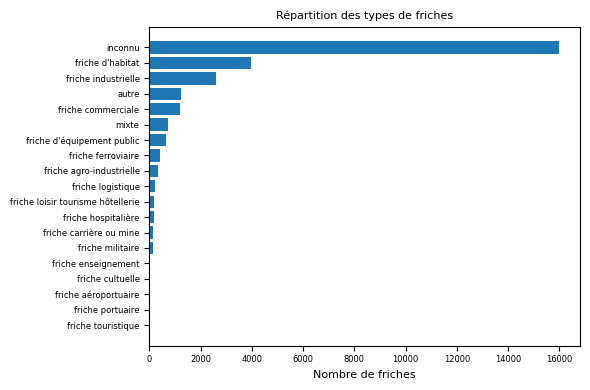

In [91]:
# Comptage des catégories sans 'inconnu'
site_counts = df["site_type"].value_counts()
site_counts = site_counts.sort_values(ascending=True)

plt.figure(figsize=(6, 4))
plt.barh(site_counts.index, site_counts.values)
plt.xlabel("Nombre de friches", fontsize=8)
plt.title("Répartition des types de friches", fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

**Commentaire:** Dans le cadre d'un modèle de machine learning il faudrait réechantilloner cette variable, et dabord résoudre les variables ambigues: comment sont réparties ces variables ambigues -> agrégation.  
🧠il y a t-il un moyen de prédire site_type en fonction des autres features

### 4) site_adress

In [37]:
detect_typo_patterns(df["site_adresse"])

,Pattern typologique,Exemple,Longueur,Fréquence
0,AAXAAAAAAA,LE VILLAGE,10,46
1,000XAAAXAAXAAAAA,259 RUE DE PLAIN,16,27
2,00XAAAXAAXAAAAAA,53 RUE DU MOULIN,16,26
3,000XAAAXAAXAAAAAAA,159 rue de Mereges,18,25
4,000XAAAXAAXAAAAAAAA,273 rue de Bordeaux,19,24
...,...,...,...,...
2092,00XAAAXAAXAXAAAAAXXAAAAAA,"33 CHE DE L USINE, SAPOIS",25,1
2093,00XAAAXAAXAXAAAAAAAA,11 rue de l'abattoir,20,1
2094,00XAAAXAAXAXAAAA,84 rue de l'Etat,16,1
2095,00XAAAXAAXAAXAXAAAAAAAA,24 rue de la République,23,1


**Commentaire:** la variable site adresse est inhomgène avec 86% de Na des typologies variables, problème de casses, des abréviations dans des cas et d'autres sans abréviation des lieux dits.  
Quels types de friches ont tendance  à ne pas avoir d'adresses? Pourquoi ? réponse partielle, **des friches sur des lieux-dits**

### 5) site_identif_date, site_actu_date

In [48]:
detect_typo_patterns(df["site_identif_date"])

,Pattern typologique,Exemple,Longueur,Fréquence
0,0000X00X00,2025-03-05,10,28083
1,00X00X00,16-10-23,8,21
2,0X00X00,6-09-23,7,11


In [58]:
detect_typo_patterns(df["site_actu_date"])

,Pattern typologique,Exemple,Longueur,Fréquence
0,0000X00X00,2025-03-05,10,28115


In [88]:
print(df.loc[mask_bad_date, "source_nom"].value_counts())
print(df.loc[mask_bad_date, "source_url"].value_counts())

source_nom
DDT de la Haute-Marne           29
Appel à projet Fonds Friches     3
Name: count, dtype: int64
source_url
https://www.haute-marne.gouv.fr/index.php/Actions-de-l-Etat/Amenagement-du-territoire-urbanisme/Observatoire-departemental-des-friches    29
https://www.economie.gouv.fr/plan-de-relance/profils/collectivites/fonds-pour-le-recyclage-des-friches                                     3
Name: count, dtype: int64


In [152]:
#réinitialisation
import pandas as pd 
import numpy as np
from datetime import datetime
df = pd.read_csv(r"C:\Users\rovar\Downloads\friches-standard.csv",sep = ";")

C:\Users\rovar\AppData\Local\Temp\ipykernel_21896\215976473.py:5: DtypeWarning:

Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.



#### Nettoyage des colonnes de dates et gestions des outliers 

In [109]:
# Nettoyage de site_identif_date
def clean_site_identif(val):
    if pd.isna(val) or not isinstance(val, str) or 'X' in val:
        return pd.NaT
    val = val.strip()
    if len(val) == 10:
        # Format standard AAAA-MM-JJ
        try:
            return pd.to_datetime(val, format="%Y-%m-%d")
        except:
            return pd.NaT
    elif len(val) in [7, 8]:
        # Format JJ-MM-AA ou J-MM-AA
        try:
            return pd.to_datetime(val, format="%d-%m-%y")
        except:
            return pd.NaT
    else:
        return pd.NaT

In [110]:
def clean_site_actu(val):
    if pd.isna(val) or not isinstance(val, str):
        return pd.NaT
    val = val.strip()

    # Cas anormal du type 0006-09-23 → on reforme une date correcte
    if val[:2] == "00":
        try:
            parts = val.split('-')
            if len(parts) != 3:
                return pd.NaT
            day = parts[0][-2:]       # ex: 0006 → 06
            month = parts[1]
            year = parts[2]           # ex: 23
            corrected = f"{year}-{month.zfill(2)}-{day.zfill(2)}"
            return pd.to_datetime(corrected, format="%y-%m-%d", errors="raise")
        except:
            return pd.NaT
    else:
        # cas normal en AAAA-MM-JJ
        try:
            return pd.to_datetime(val, format="%Y-%m-%d", errors="raise")
        except:
            return pd.NaT

In [111]:
# Application
df['site_identif_date'] = df['site_identif_date'].apply(clean_site_identif)
df['site_actu_date'] = df['site_actu_date'].apply(clean_site_actu)

In [117]:
# Calcul du délai en jours
df["délai_maj"] = (df["site_actu_date"] - df["site_identif_date"]).dt.days

# Filtrer les valeurs aberrantes (négatives)
outliers_date = df[df["délai_maj"] < 0]

In [119]:
df[["site_actu_date", "site_identif_date","délai_maj"]].describe()

,site_actu_date,site_identif_date,délai_maj
count,28115,28115,28115.000000
mean,2023-01-09 03:55:02.422194176,2022-02-20 04:40:12.889916672,322.968629
min,2014-01-01 00:00:00,1900-12-31 00:00:00,-2848.000000
25%,2022-10-10 00:00:00,2022-10-10 00:00:00,0.000000
50%,2022-10-10 00:00:00,2022-10-10 00:00:00,0.000000
75%,2024-01-30 00:00:00,2022-10-10 00:00:00,0.000000
max,2025-04-07 00:00:00,2031-12-01 00:00:00,44969.000000
std,NaN,NaN,1811.575284


In [118]:
outliers_date

,site_id,site_nom,site_type,site_adresse,site_identif_date,site_actu_date,site_url,site_ademe_url,site_securite,site_occupation,...,urba_doc_type,desserte_distance,desserte_commentaire,source_nom,source_url,source_producteur,source_contact,geompoint,geomsurf,délai_maj
16468,37027_21675,Appel à projet Recyclage Foncier 2021 3ième éd...,friche d'habitat,NaN,2031-12-01,2024-02-13,NaN,NaN,inconnu,inconnu,...,PLUI,NaN,NaN,Appel à projet Fonds Friches,https://www.economie.gouv.fr/plan-de-relance/p...,Appel à projet Fonds Friches,NaN,POINT (0.9920944 47.32845),NaN,-2848
19623,37027_20243,"Appel à projet Fonds Vert 2023 -BLERE ""Square ...",mixte,NaN,2031-12-01,2024-02-13,NaN,NaN,inconnu,inconnu,...,PLUI,NaN,NaN,Appel à projet Fonds Friches,https://www.economie.gouv.fr/plan-de-relance/p...,Appel à projet Fonds Friches,NaN,POINT (0.9927726 47.32828),NaN,-2848
25567,37104_25534,"Appel à projet Fonds Vert 2023 -ESVRES ""Rue du...",mixte,NaN,2031-12-01,2024-02-13,NaN,NaN,inconnu,inconnu,...,PLU,NaN,NaN,Appel à projet Fonds Friches,https://www.economie.gouv.fr/plan-de-relance/p...,Appel à projet Fonds Friches,NaN,POINT (0.7889918 47.28532),NaN,-2848


In [39]:
outliers_date

,site_id,site_nom,site_type,site_adresse,site_identif_date,site_actu_date,site_url,site_ademe_url,site_securite,site_occupation,...,desserte_commentaire,source_nom,source_url,source_producteur,source_contact,geompoint,geomsurf,site_actu_date_raw,site_identif_date_raw,délai_maj
16468,37027_21675,Appel à projet Recyclage Foncier 2021 3ième éd...,friche d'habitat,NaN,2031-12-01,2024-02-13,NaN,NaN,inconnu,inconnu,...,NaN,Appel à projet Fonds Friches,https://www.economie.gouv.fr/plan-de-relance/p...,Appel à projet Fonds Friches,NaN,POINT (0.9920944 47.32845),NaN,2024-02-13,1-12-31,-2848.0
19623,37027_20243,"Appel à projet Fonds Vert 2023 -BLERE ""Square ...",mixte,NaN,2031-12-01,2024-02-13,NaN,NaN,inconnu,inconnu,...,NaN,Appel à projet Fonds Friches,https://www.economie.gouv.fr/plan-de-relance/p...,Appel à projet Fonds Friches,NaN,POINT (0.9927726 47.32828),NaN,2024-02-13,1-12-31,-2848.0
25567,37104_25534,"Appel à projet Fonds Vert 2023 -ESVRES ""Rue du...",mixte,NaN,2031-12-01,2024-02-13,NaN,NaN,inconnu,inconnu,...,NaN,Appel à projet Fonds Friches,https://www.economie.gouv.fr/plan-de-relance/p...,Appel à projet Fonds Friches,NaN,POINT (0.7889918 47.28532),NaN,2024-02-13,1-12-31,-2848.0


📊 Moyenne des délais (≤ 45000 jours) : 184.09 jours
🔹 Médiane : 0 jours
± Écart type : 829.99 jours
📈 Nombre de points : 27859 / 27859


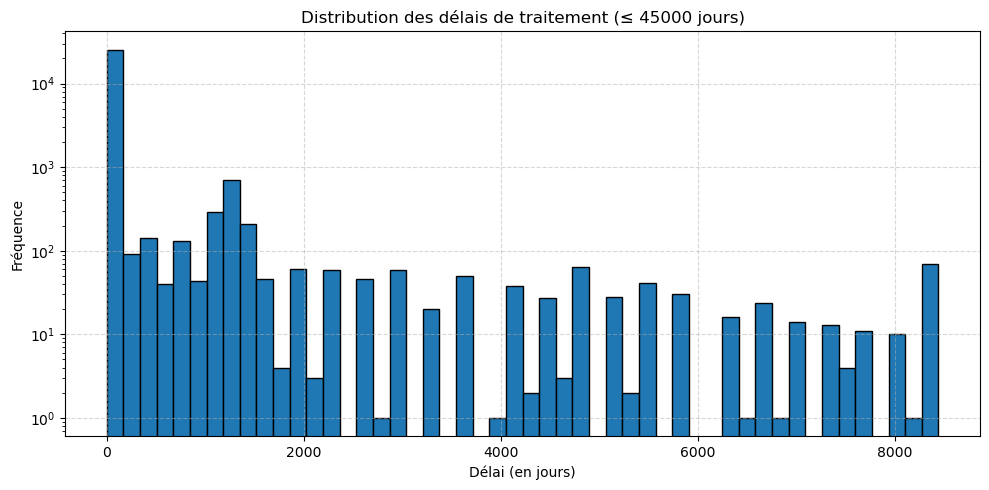

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcul du délai
df['delai_jours'] = (df['site_actu_date'] - df['site_identif_date']).dt.days

# Filtrage : dates valides entre 2000 et 2025 + délai positif
mask_valid = (
    df['site_identif_date'].dt.year.between(2000, 2025) &
    df['site_actu_date'].dt.year.between(2000, 2025) &
    df['delai_jours'].notna()
)

df_valid = df.loc[mask_valid]

# Définir une fenêtre de délai raisonnable (ex : 0 à 45000 jours) 
delai_max = 45000
df_windowed = df_valid[df_valid['delai_jours'].between(0, delai_max)]

# Statistiques sur la fenêtre sélectionnée
mean_ = df_windowed['delai_jours'].mean()
median_ = df_windowed['delai_jours'].median()
std_ = df_windowed['delai_jours'].std()

print(f"📊 Moyenne des délais (≤ {delai_max} jours) : {mean_:.2f} jours")
print(f"🔹 Médiane : {median_:.0f} jours")
print(f"± Écart type : {std_:.2f} jours")
print(f"📈 Nombre de points : {len(df_windowed)} / {len(df_valid)}")

# Histogramme
plt.figure(figsize=(10, 5))
df_windowed['delai_jours'].hist(bins=50, edgecolor='black')
plt.title(f"Distribution des délais de traitement (≤ {delai_max} jours)")
plt.xlabel("Délai (en jours)")
plt.ylabel("Fréquence")
plt.yscale("log")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Ces variables sont les seules variables temporielles que l'on a elles indiquent la date de saisie des données et leurs mises a jour site_actu date est un bon indicateur de la qualité de la maintenance du site.  
On peut estimer le délai de mise a jour moyen des données, et aussi la récurence de ces mises à jour, il nous manquerai juste une information si jamais il y a des mises a jour multiples.
On peut aussi déterminer la fréquence des mises à jour.

In [43]:
df["site_actu_date"] = pd.to_datetime(df["site_actu_date"], errors='coerce')

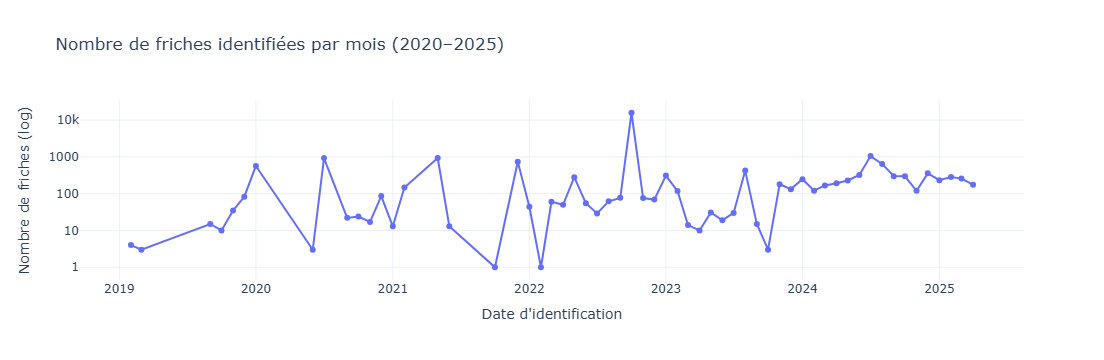

In [92]:
import plotly.express as px

# Filtrage sur les dates entre 2019 et 2025
mask_years = df["site_identif_date"].dt.year.between(2019, 2025)
df_filtered = df.loc[mask_years].copy()

# Agrégation par mois
df_filtered['periode'] = df_filtered['site_identif_date'].dt.to_period('M').dt.to_timestamp()

# Comptage par mois
agg = df_filtered['periode'].value_counts().sort_index().reset_index()
agg.columns = ['Date', 'Nombre de friches']

# Plot avec échelle log
fig = px.line(
    agg,
    x='Date',
    y='Nombre de friches',
    title='Nombre de friches identifiées par mois (2020–2025)',
    markers=True
)

fig.update_layout(
    xaxis_title="Date d'identification",
    yaxis_title="Nombre de friches (log)",
    yaxis_type='log',
    template="plotly_white"
)

fig.show()

**Commentaire:** Il y a une activité importante en 2022 avec un ajout de 15859 lignes,  les 5 plus  grands fournisseurs de données sur cette période sont:
| Description                                               | Nombre |
|-----------------------------------------------------------|--------|
| Site Basias ou Basol non vérifié par le Cerema            | 12906  |
| Friche étude Ademe 2021                                   |   925  |
| Site Basias ou Basol vérifié par le Cerema en 2020        |   845  |
| Friche étude Ademe 2021, intéressante pour du PV au sol   |   698  |


## 6) source des donnees

dans cette partie nous nous interesserons aux sources des données 
|colonne              |               Description de la colonne|
|---------------------|-------------------------------------------------|
|site_url	          |URL du site, ou de la fiche BASOL ou BASIAS|
|site_ademe_url	      |URL de la fiche lorsque le site a fait l'objet d'une intervention de l'ADEME|
|site_projet_url	  |Lien vers un projet associé (rare)|
|source_nom	          |Nom de la source ayant permis l’identification du site|
|source_url	          |Lien vers la source (ex. data.gouv.fr, etc.)|
|source_producteur	  |Nom de la structure ou auteur|
|source_contact	      |Email de contact de la donnée|
|sol_depollution_fiche|Lien vers une fiche BRGM (pollution)|

In [153]:
# Colonnes liées aux sources et URLs
colonnes_sources = [
    'site_url',
    'site_ademe_url',
    'site_projet_url',
    'source_nom',
    'source_url',
    'source_producteur',
    'source_contact',
    'sol_depollution_fiche'
]
total = len(df)

# Audit qualité
audit = []
for col in colonnes_sources:
    non_na = df[col].notna().sum()
    pct = (non_na / total * 100) if total > 0 else 0
    audit.append({
        'Colonne': col,
        'Valeurs non nulles': non_na,
        'Complétion (%)': round(pct, 2),
        'Total': total
    })

df_audit_sources = pd.DataFrame(audit).sort_values(by='Complétion (%)', ascending=False).reset_index(drop=True)
df_audit_sources

,Colonne,Valeurs non nulles,Complétion (%),Total
0,source_nom,28115,100.00,28115
1,source_producteur,28115,100.00,28115
2,source_url,21475,76.38,28115
3,site_url,16995,60.45,28115
4,source_contact,2336,8.31,28115
5,sol_depollution_fiche,3,0.01,28115
6,site_ademe_url,0,0.00,28115
7,site_projet_url,0,0.00,28115


In [154]:
df['source_nom'].value_counts(dropna=False)

source_nom
Site Basias ou Basol non vérifié par le Cerema                             12906
EPF Normandie                                                               4170
Appel à projet Fonds Friches                                                2998
Grand Angoulême                                                             2185
EPF Grand Est                                                               1460
Friche étude Ademe 2021                                                      925
Site Basias ou Basol vérifié par le Cerema en 2020                           845
Friche étude Ademe 2021, intéressante pour du PV au sol                      698
DDT de la Somme                                                              493
urban vitaliz                                                                230
DDT de l'Ain                                                                 207
Institut Paris Région                                                        163
Communauté de Com

In [155]:
df['source_nom_simpl'] = df['source_nom'].str.extract(
    r"(Basias|Basol|Ademe|Cerema)", expand=False
).fillna("Autre")
df['source_nom_simpl'].value_counts()


source_nom_simpl
Basias    13751
Autre     12624
Ademe      1623
Cerema      117
Name: count, dtype: int64

⚠️ essayer de chercher les données ici pour la pollution des sols:
https://www.georisques.gouv.fr/consulter-les-dossiers-thematiques/dossier-expert-sur-les-sites-et-sols-potentiellement-pollues

In [162]:
df['site_url'].value_counts().loc[lambda x: x > 1]

site_url
https://www.suippes.fr/9143-2/                                                                                                                                                                              14
https://fiches-risques.brgm.fr/georisques/basias-detaillee/LRO6602417                                                                                                                                       13
https://fiches-risques.brgm.fr/georisques/basias-detaillee/NA                                                                                                                                               10
https://www.google.com/maps/@45.5922396,0.1766609,3a,72.8y,317.09h,84.27t/data=!3m6!1e1!3m4!1smpDybbJGI3Por8GFLoUS9Q!2e0!7i13312!8i6656?authuser=0&entry=ttu                                                 3
https://www.google.com/maps/@45.6578379,0.1552262,3a,49y,83.63h,93.82t/data=!3m6!1e1!3m4!1sgj9hSYBAmVZzjbX3ozeMvQ!2e0!7i16384!8i8192?authuser=0&entry=ttu          

 # Pollution
 Champ Champ Description Description  
 sol_pollution_annee Année de constation de la pollution dans BASOL  
 sol_pollution_existe Existence de pollution du sol  
 sol_pollution_origine Origine de la pollution du sol  
 sol_pollution_commentaire Commentaire décrivant la pollution, le cas échéant  
 sol_depollution_fiche Lien vers la fiche de dépollution si elle est présente dans  

## Analyse  de la qualité du Dataset avec des "colonnes obligatoires"

In [24]:
# Liste exacte des colonnes obligatoires selon Cartofriches
colonnes_obligatoires = [
    "site_id", "site_nom", "site_type",
    "site_identif_date", "site_actu_date",
    "comm_nom", "comm_insee",
    "source_nom", "geompoint"
]

# Chargement uniquement de ces colonnes
df_obligatoires = pd.read_csv(
    r"C:\Users\rovar\Downloads\friches-standard.csv",
    sep=";",                      # adapte si besoin
    usecols=colonnes_obligatoires,
    encoding="utf-8-sig",         # change si tu as des caractères bizarres
    low_memory=False
)

df_obligatoires.head(5)

,site_id,site_nom,site_type,site_identif_date,site_actu_date,comm_nom,comm_insee,source_nom,geompoint
0,61214_34555,rue de la garenne,friche d'habitat,2025-03-05,2025-03-05,L'Aigle,61214,EPF Normandie,POINT (0.6256966 48.76207)
1,57097_23384,Sotralec,friche industrielle,2022-01-01,2022-01-01,BOULAY-MOSELLE,57097,EPF Grand Est,POINT (6.49563 49.17622)
2,93027_35701,93027_35701,autre,2025-04-07,2025-04-07,La Courneuve,93027,Institut Paris Région,POINT (2.413969 48.93915)
3,80126_24311,80126_24311,mixte,2023-08-17,2023-08-17,BOUTTENCOURT,80126,DDT de la Somme,POINT (1.60458 49.94721)
4,61386_34635,Les Futiaux,friche d'habitat,2024-08-13,2024-08-13,Saint-Evroult-Notre-Dame-du-Bois,61386,EPF Normandie,POINT (0.4367191 48.79385)


In [25]:
#valeurs manquantes sur les colonnes obligatoires:
df_obligatoires.isna().sum()
#Redéfinir pourquoi les colonnes sont obligatoires

site_id                0
site_nom               0
site_type              0
site_identif_date      0
site_actu_date         0
comm_nom             132
comm_insee           132
source_nom             0
geompoint              0
dtype: int64

In [26]:
# Vérification des lignes manquantes
missing_comm_nom = df_obligatoires["comm_nom"].isnull()
missing_comm_insee = df_obligatoires["comm_insee"].isnull()

# Vérifie si les lignes sont les mêmes
same_missing = (missing_comm_nom == missing_comm_insee).all()
matching_indices = df_obligatoires[missing_comm_nom & missing_comm_insee].index.tolist()

print("Les lignes manquantes sont-elles identiques :", same_missing)
print("Nombre de lignes concernées :", len(matching_indices))

Les lignes manquantes sont-elles identiques : True
Nombre de lignes concernées : 132


ref : https://www.bing.com/search?pglt=297&q=urbansimul&cvid=82b30ecbddb849a39757db90987acd2d&gs_lcrp=EgRlZGdlKgYIABBFGDkyBggAEEUYOTIGCAEQABhAMgYIAhAAGEAyBggDEAAYQDIGCAQQABhA0gEIMTU3MGowajGoAgCwAgA&FORM=ANNTA1&PC=DCTS

## Annexe
🔍 Sigles fréquents et leur signification
|Sigle|	Nom complet|	Rôle principal|
|-----|------------|------------------|
|EPF	|Établissement Public Foncier	|Opérateur foncier public (rachète, gère, réhabilite les friches)
|DDT	|Direction Départementale des Territoires	|Services de l’État à l’échelle départementale (aménagement, foncier, urbanisme)
|DREAL	|Direction Régionale de l’Environnement, de l’Aménagement et du Logement	|Coordination régionale pour l'environnement, urbanisme, risques
|ADEME	|Agence de la Transition Écologique	|Études et accompagnement sur les friches, pollutions, reconversions
|BRGM	|Bureau de Recherches Géologiques et Minières	|Expertise sol, pollution, géorisques ; édite les fiches pollution
|CEREMA	|Centre d'Études et d'Expertise sur les Risques, l’Environnement, la Mobilité et l’Aménagement	|Appui technique aux territoires (carto, friches, observatoires)
|IGN	|Institut national de l'information géographique et forestière	|Fournisseur de données spatiales et cartographiques
|ANCT	|Agence Nationale de la Cohésion des Territoires	|Soutien aux collectivités pour l'aménagement, la reconversion
|DEAL	|Direction de l’Environnement, de l’Aménagement et du Logement (en Outre-mer)	|Équivalent DREAL dans les DOM-TOM
|Insee	|Institut national de la statistique et des études économiques	|Données démographiques, socio-éco, INSEE codes (communes, etc.)
|Basias	|Base de données des Anciens Sites Industriels et Activités de Service	|Inventaire des sites industriels potentiellement pollués
|Basol	|Base des Sites et Sols Pollués	|Sites nécessitant une action de l’État ou un suivi réglementaire
|Cartofriche	|Plateforme de visualisation des friches	|Portail de consultation des données Cerema, ADEME, etc.
|Géorisques	|Portail d'information sur les risques naturels et technologiques	|Données BRGM, fiches pollution, mouvements de terrain, etc.